# Node Pair Feature Ranking, with Ground Truth Communities

Taking all node pairs from all graphs (across all mu levels), pairs are classified into "same community" or "different community" based on the ground truth communities, i.e. no runs of any community finding algorithm are involved.

In [17]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

### Gathering the Data
The node pair features have been generated, but not yet split into train and test sets, as the classification labels haven't been determined. We will read in all of the node pairs, determine their labels, then split them into stratified train and test sets, so there is the same proportion of "same community" pairs in both train and test.

In [3]:
X = pd.read_csv('../node_pairs_x.csv', index_col=0)

In [35]:
classification_values = []
indices = []

for mu in [1,2,3,4]:
    for g_num in [1,2,3,4,5]:
        graph_yml = '../lfr_graphs/mu_0_{0}/graph_0{1}/graph_0{1}_mu_0_{0}.yml'.format(mu, g_num)
        with open(graph_yml) as f:
            graph_info = yaml.load(f, Loader=yaml.Loader)
        comms = graph_info['community_integer_labels']
        for node1 in range(200):
            for node2 in range(node1 + 1, 200):
                bin_val = 0
                if comms[node1] == comms[node2]:
                    bin_val = 1
                classification_values.append(bin_val)
                indices.append('graph_{0}_{1}_nodes_{2}_{3}'.format(mu, g_num, node1, node2))
                
y = pd.DataFrame(classification_values, index=indices, columns=['Same Community'])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [38]:
X_train.to_csv('../node_pair_gt_x_train.csv')
X_test.to_csv('../node_pair_gt_x_test.csv')
y_train.to_csv('../node_pair_gt_y_train.csv')
y_test.to_csv('../node_pair_gt_y_test.csv')

### Train subset

Due to the very large number of data points in the node pair dataset, we select a subset of 4000 of these for training the random forest and save these in a separate CSV file.

In [15]:
X_train = pd.read_csv('node_pair_gt_x_train.csv', index_col=0)
y_train = pd.read_csv('node_pair_gt_y_train.csv', index_col=0)

ts = len(X_train) - 4000

X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=ts)

X_train.to_csv('../node_pair_gt_x_train_subset.csv')
y_train.to_csv('../node_pair_gt_y_train_subset.csv')

### Feature ranking with random forest

Now we're going to perform the node feature ranking using a random forest. During training, we will use a stratified k-fold cross-validation scheme.

In [18]:
runs = 100

In [19]:
feature_list = list(X_train.columns)
data = np.array(X_train)
labels = np.squeeze(np.array(y_train))

In [20]:
accuracy_scores = []
feature_importances = {}
for f in feature_list:
    feature_importances[f] = []
rows = []

skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier(n_jobs=-1)

fold_count = 0

for run in range(1, runs+1):
    
    for i in range(5):
        
        fold_count += 1
        
        folds = next(skf.split(data, labels), None)
        
        X_train_fold = data[folds[0], :]
        X_val_fold = data[folds[1], :]
        y_train_fold = labels[folds[0]]
        y_val_fold = labels[folds[1]]
        
        model = rf.fit(X_train_fold, y_train_fold)
        predictions = rf.predict(X_val_fold)
    
        accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))

        row = { "run" : fold_count }
        for j, feature in enumerate(feature_list):
            row[feature] = rf.feature_importances_[j]
        rows.append(row)

### Check accuracy scores

Let's have a look at the accuracy scores to make sure the model is working.

In [21]:
print(accuracy_scores[:100])
print('~~~~~~~~~~~~~~~~~~~~~')
print(np.mean(accuracy_scores))

[0.90125, 0.9025, 0.90625, 0.90375, 0.905, 0.90875, 0.90125, 0.9075, 0.90625, 0.905, 0.90375, 0.90875, 0.9075, 0.9075, 0.90125, 0.9025, 0.90375, 0.90625, 0.905, 0.905, 0.9075, 0.90375, 0.9025, 0.90375, 0.90375, 0.90875, 0.90375, 0.90625, 0.90625, 0.9025, 0.90125, 0.90625, 0.90625, 0.90625, 0.90625, 0.90375, 0.90125, 0.90875, 0.90375, 0.905, 0.90375, 0.90375, 0.905, 0.905, 0.90625, 0.8975, 0.90625, 0.90625, 0.9075, 0.9025, 0.9, 0.9, 0.90625, 0.9025, 0.9025, 0.905, 0.90375, 0.9025, 0.90625, 0.9075, 0.905, 0.90625, 0.905, 0.89375, 0.90625, 0.90625, 0.9075, 0.9025, 0.9075, 0.905, 0.905, 0.90875, 0.90625, 0.8975, 0.89875, 0.905, 0.9075, 0.89625, 0.9025, 0.89875, 0.9075, 0.9025, 0.90625, 0.91, 0.90375, 0.9025, 0.9075, 0.905, 0.9025, 0.9025, 0.905, 0.90625, 0.905, 0.9, 0.90625, 0.91, 0.905, 0.90125, 0.9075, 0.905]
~~~~~~~~~~~~~~~~~~~~~
0.9046700000000001


In [22]:
df_importances = pd.DataFrame(rows).set_index("run")

In [23]:
feature_ranking = df_importances.mean().sort_values(ascending=False)

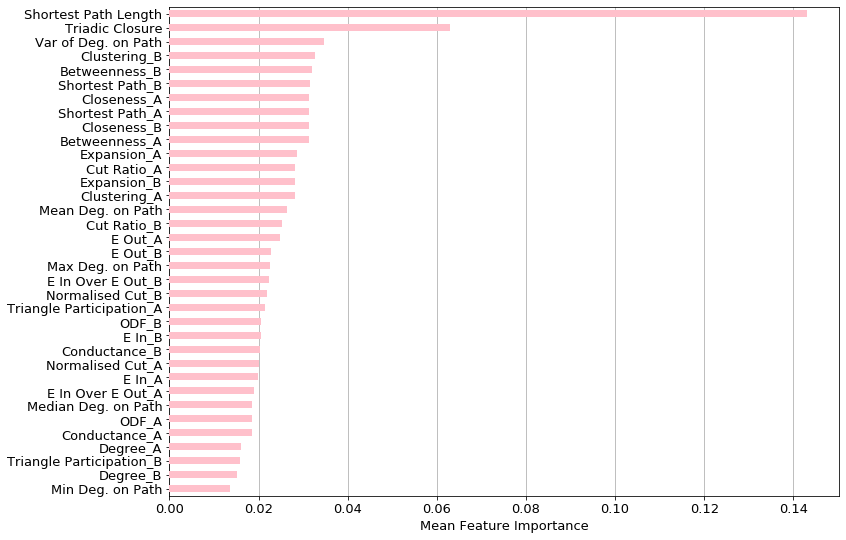

In [24]:
ax = feature_ranking[::-1].plot.barh(fontsize=13, figsize=(12,9), color="pink", zorder=3)
ax.set_xlabel("Mean Feature Importance", fontsize=13)
ax.xaxis.grid()